[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/benchmarking.ipynb)

# Running benchmarking experiments
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

# we also need prophet for this notebook
# !pip install prophet

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark
set_log_level("ERROR")

Importing plotly failed. Interactive plots will not work.
INFO - (NP.benchmark.<module>) - Note: The benchmarking framework is not properly documented.Please help us by reporting any bugs and adding documentation.Multiprocessing is not covered by tests and may break on your device.If you use multiprocessing, only run one benchmark per python script.


## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
# retail_sales_df = pd.read_csv(data_location + 'retail_sales.csv')
# yosemite_temps_df = pd.read_csv(data_location +  'yosemite_temps.csv')
# ercot_load_df = pd.read_csv(data_location +  'ERCOT_load.csv')[['ds', 'y']]

## 0. Configure Datasets and Model Parameters
First, we define the datasets that we would like to benchmerk on.
Next, we define the models that we want to evaluate and set their hyperparameters.

In [3]:
dataset_list = [
    Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS"),
    # Dataset(df = peyton_manning_df, name = "peyton_manning", freq = "D"),
    # Dataset(df = retail_sales_df, name = "retail_sales", freq = "D"),
    # Dataset(df = yosemite_temps_df, name = "yosemite_temps", freq = "5min"),
    # Dataset(df = ercot_load_df, name = "ercot_load", freq = "H"),
]
model_classes_and_params = [
    (NeuralProphetModel, {"seasonality_mode": "multiplicative", "learning_rate": 0.1}),
    (ProphetModel, {"seasonality_mode": "multiplicative"})
]

Note: As all the classes used in the Benchmark framework are dataclasses, 
they have a print function, allowing us to peek into them if we like:

In [4]:
model_classes_and_params

[(neuralprophet.benchmark.NeuralProphetModel,
  {'seasonality_mode': 'multiplicative', 'learning_rate': 0.1}),
 (neuralprophet.benchmark.ProphetModel,
  {'seasonality_mode': 'multiplicative'})]

## 1. SimpleBenchmark
Setting up a series of Train Test Experiments is quick:

In [5]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE", "MASE", "RMSE"],
    test_percentage=25,
)
results_train, results_test = benchmark.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.35721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.095   0.000197806       75.6156     0.07304           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       383.482   0.000187545       141.645   1.283e-06       0.001      179  LS failed, Hessian reset 
     159       384.105   0.000328631       165.657   3.031e-06       0.001      277  LS failed, Hessian reset 
     199       384.233   0.000179066       78.5608      0.4924      0.4924      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       385.249    0.00016096       76.7537      0.2907      0.2907      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       385.282   9.21668e-05       100.953   1.111e-06       0.001      501  LS failed, Hessian rese

In [6]:
results_test

,data,model,params,MAE,MSE,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.027794,795.101013,1.182601,28.197536
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.818647,1142.139160,1.467615,33.795551


## 2. CrossValidationBenchmark
Setting up a series of crossvalidated experiments is just as simple:

In [ ]:
benchmark_cv = CrossValidationBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MASE", "RMSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
)
results_summary, results_train, results_test = benchmark_cv.run()

We now also get a summary DataFrame showing the metrics' mean and standard deviation over all folds.

In [8]:
results_summary

,data,model,params,MASE,RMSE,MASE_std,RMSE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.280458,7.657820,0.011841,0.713385,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.310869,8.616463,0.021078,1.266764,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.880757,21.963869,0.244119,5.522509,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.893797,22.778341,0.161704,4.224042,test


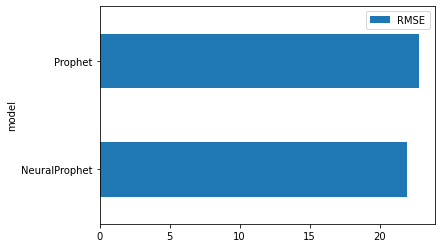

In [9]:
air_passengers = results_summary[results_summary['data'] == 'air_passengers']
air_passengers = air_passengers[air_passengers['split'] == 'test']
plt = air_passengers.plot(x='model', y='RMSE', kind='barh')

The metrics for each fold are also recoreded individually:

In [10]:
results_test

,data,model,params,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...","[0.8573083, 0.5941888, 1.1907747]","[20.638454, 15.961023, 29.292131]"
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},"[1.0298454, 0.66658664, 0.9849584]","[24.617702, 16.936632, 26.780687]"


## 3. Manual Benchmark
If you need more control over the individual Experiments, you can set them up manually:

In [11]:
from neuralprophet.benchmark import SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import ManualBenchmark, ManualCVBenchmark

### 3.1 ManualBenchmark: Manual SimpleExperiment Benchmark

In [ ]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
metrics = ["MAE", "MSE", "RMSE", "MASE", "RMSSE", "MAPE", "SMAPE"]
experiments = [
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"learning_rate": 0.1},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
]
benchmark = ManualBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_train, results_test = benchmark.run()

In [13]:
results_test

,data,model,params,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.005142,793.559387,28.170187,1.181486,1.090349,5.773936,2.777174
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.818647,1142.139160,33.795551,1.467615,1.308083,7.471930,3.558547
2,peyton_manning,NeuralProphet,{'learning_rate': 0.1},0.575561,0.446854,0.668472,1.870918,1.411006,7.394003,3.551846
3,peyton_manning,Prophet,{},0.597307,0.465471,0.682255,1.941605,1.440099,7.704831,3.697093


### 3.2 ManualCVBenchmark: Manual CrossValidationExperiment Benchmark

In [ ]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
experiments = [
    CrossValidationExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
    CrossValidationExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
]
benchmark_cv = ManualCVBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_summary, results_train, results_test = benchmark_cv.run()

In [15]:
results_summary

,data,model,params,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,MAE_std,MSE_std,RMSE_std,MASE_std,RMSSE_std,MAPE_std,SMAPE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",5.996241,59.247303,7.662074,0.281055,0.279981,3.043633,1.511519,0.633657,10.927888,0.734798,0.012510,0.013638,0.079835,0.040635,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},6.655735,75.848122,8.616463,0.310869,0.313269,3.089578,1.553327,0.952938,20.968357,1.266764,0.021078,0.023619,0.261420,0.132790,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",19.368925,522.388733,22.173418,0.894181,0.802707,4.570522,2.310261,6.710804,258.608643,5.543307,0.240341,0.144602,1.391520,0.738841,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},19.052099,536.695312,22.778341,0.893797,0.835219,4.604149,2.272174,3.876074,182.404541,4.224042,0.161704,0.157025,0.710556,0.353903,test
